# Data Preprocessing

## Dataset Description

| Column | Type | Discription |
| ----- | ------- | ---------- |
| reference | str | First item from the pair |
| ref_tox | float | toxicity level of reference text |
| translation | str | Second item from the pair - paraphrazed version of the reference|
| trn_tox | float | toxicity level of translation text |
| similarity | float | cosine similarity of the texts |
| lenght_diff | float | relative length difference between texts |

## 1. Importing Libraries

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

## 2. Importing Dataset

In [2]:
dataset = pd.read_csv('../data/raw/filtered_paramnt/filtered.tsv', delimiter='\t', quoting=3, index_col=0)

In [3]:
dataset.head()

,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
0,"If Alkar is flooding her with psychic waste, t...","if Alkar floods her with her mental waste, it ...",0.785171,0.010309,0.014195,0.981983
1,Now you're getting nasty.,you're becoming disgusting.,0.749687,0.071429,0.065473,0.999039
2,"Well, we could spare your life, for one.","well, we can spare your life.",0.919051,0.268293,0.213313,0.985068
3,"Ah! Monkey, you've got to snap out of it.","monkey, you have to wake up.",0.664333,0.309524,0.053362,0.994215
4,I've got orders to put her down.,I have orders to kill her.,0.726639,0.181818,0.009402,0.999348


## 3. Preprocessing

### 3.1. Cleaning Text

In [4]:
import re
import random
import nltk
from tqdm import tqdm
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/levrekhlov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
corpus = []
ps = PorterStemmer()

indices = random.sample(range(len(dataset)), 200000)

print("Random sample:")
for i in tqdm(indices, desc="Cleaning text"):
    review = re.sub('[^a-zA-Z]', ' ', dataset['reference'][i])
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review)
    corpus.append(review)

    if random.randint(0, 200000) == 0:
        print('-' * 30)
        print("Index:", i)
        print("Before:", dataset['reference'][i])
        print("After:", review)

Random sample:


Cleaning text: 100%|██████████| 200000/200000 [01:58<00:00, 1686.41it/s]


### 3.2. Train toxicity classifier

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

cv = TfidfVectorizer(max_features=1000)
X = cv.fit_transform(corpus).toarray()
y = dataset['ref_tox'][indices].values > 0.5

In [51]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

In [52]:
from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB()

In [53]:
y_pred = classifier.predict(X_test)

<Axes: xlabel='col_0', ylabel='row_0'>

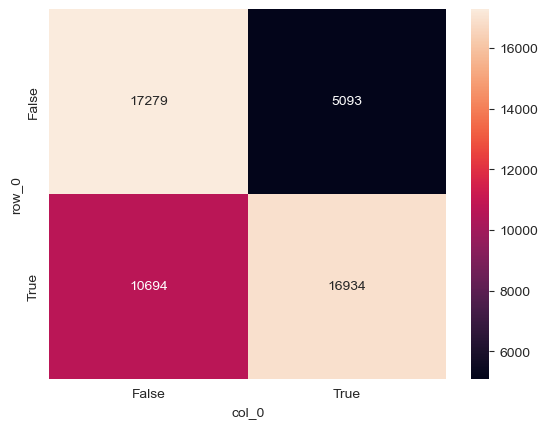

In [54]:
import seaborn as sns

sns.heatmap(pd.crosstab(y_test, y_pred), annot=True, fmt='d')

In [55]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.62      0.77      0.69     22372
        True       0.77      0.61      0.68     27628

    accuracy                           0.68     50000
   macro avg       0.69      0.69      0.68     50000
weighted avg       0.70      0.68      0.68     50000



### 3.3 Save vectorizer and classifier

In [56]:
import pickle

with open('../models/toxicity_classifier.pkl', 'wb') as f:
    pickle.dump(classifier, f)

In [57]:
with open('../models/toxicity_vectorizer.pkl', 'wb') as f:
    pickle.dump(cv, f)